GRU with attention

with assistance from: https://www.kaggle.com/code/archis2004/img-to-caption-8-0/notebook#Model-training

In [1]:
# training a image captioning model
print("does the ntoebook work")

does the ntoebook work


In [2]:
import sys
print(sys.executable)

/usr/bin/python3


In [3]:
! source ~/.zshrc

/bin/bash: line 1: /root/.zshrc: No such file or directory


In [4]:
! which pip3
! echo $PATH
! which python3

/usr/local/bin/pip3
/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
/usr/bin/python3


In [5]:
import torch
# import keras
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

from PIL import Image
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score



In [6]:
! pip install -q kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avikapadia","key":"7987f4d77fa26d479331ed7a472bf7c5"}'}

In [8]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets list

ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                        1MB  2024-04-10 09:48:38           8422        178  1.0              
jaceprater/smokers-health-data                                   Smoker's Health Data                              29KB  2024-04-20 17:09:38           1838         25  1.0              
mexwell/heart-disease-dataset                                    🫀 Heart Disease Dataset                          399KB  2024-04-08 09:43:49           4261         76  1.0              
sujithmandala/second-hand-car-price-prediction                   Secon

In [11]:
!kaggle datasets download -d "adityajn105/flickr8k"

100% 1.03G/1.04G [00:47<00:00, 25.0MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.3MB/s]


In [ ]:
!unzip flickr8k.zip

In [13]:
# load data from flickr8k dataset
image_path = 'Images'
description_path = 'captions.txt'
# load descriptions



In [14]:
images = image_path

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))
txt_file = description_path

def load_doc(filename):
    open_file = open(txt_file, 'r', encoding='latin-1')
    txt = open_file.read()
    open_file.close()

    return txt

doc = load_doc(txt_file)
print(doc[:500])

The total images present in the dataset: 8091
image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [15]:
imgs = image_path

img_id = [] # All image ID
img_path = [] # All image paths
captions = [] # All captions

with open(description_path , 'r') as fo:
    next(fo)
    for line in fo :
        split_arr = line.split(',')
        img_id.append(split_arr[0])
        captions.append(split_arr[1].rstrip('\n.'))
        img_path.append(imgs + "/" + split_arr[0])

df = pd.DataFrame(list(zip(img_id, img_path, captions)),columns =['Image ID','Image Path','Captions'])

df

Image ID                        Image Path  \
0      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Images/1000268201_693b08cb0e.jpg   
...                          ...                               ...   
40450   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [16]:
vocab = [word.lower() for line in captions for word in line.split()]
counter = Counter(vocab)

for word, count in counter.most_common(10):
    print(word, " has ", count, " instances")


a  has  60196  instances
in  has  18174  instances
the  has  17507  instances
on  has  10357  instances
is  has  9069  instances
and  has  8057  instances
dog  has  7948  instances
with  has  7304  instances
man  has  7137  instances
of  has  6495  instances


In [17]:
def plot_img_cap(img_id, df) :
    capt = ("\n" *2).join(df[df['Image ID'] == img_id]['Captions'].to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx = df['Image ID'].to_list().index(img_id)
    im = Image.open(df['Image Path'].iloc[idx])
    w, h = im.size[0], im.size[-1]
    ax.imshow(im)
    ax.text(w+50, h, capt, fontsize = 18, color = 'navy')

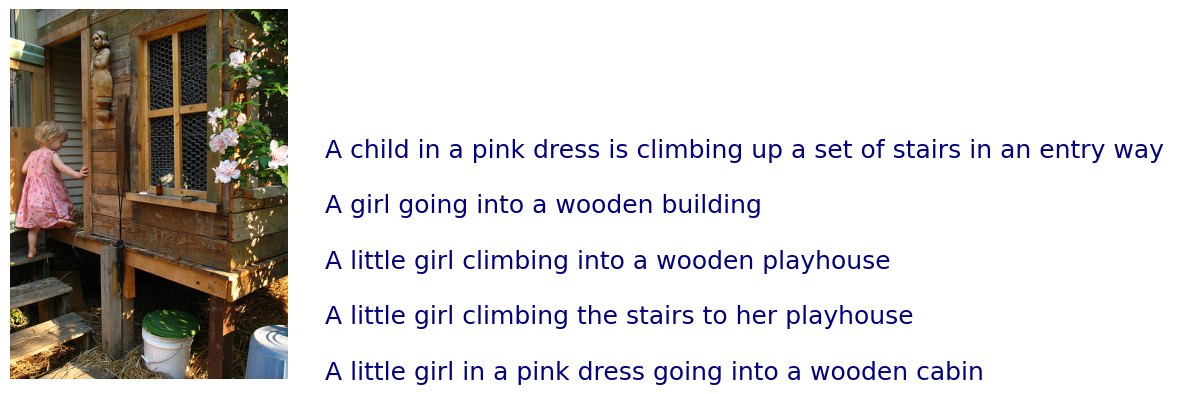

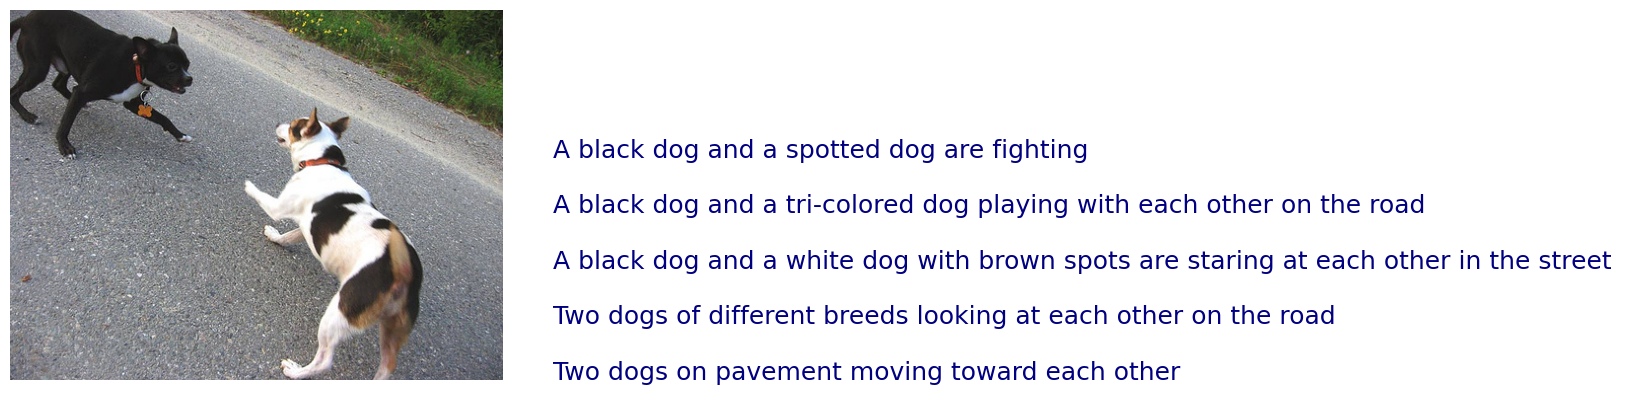

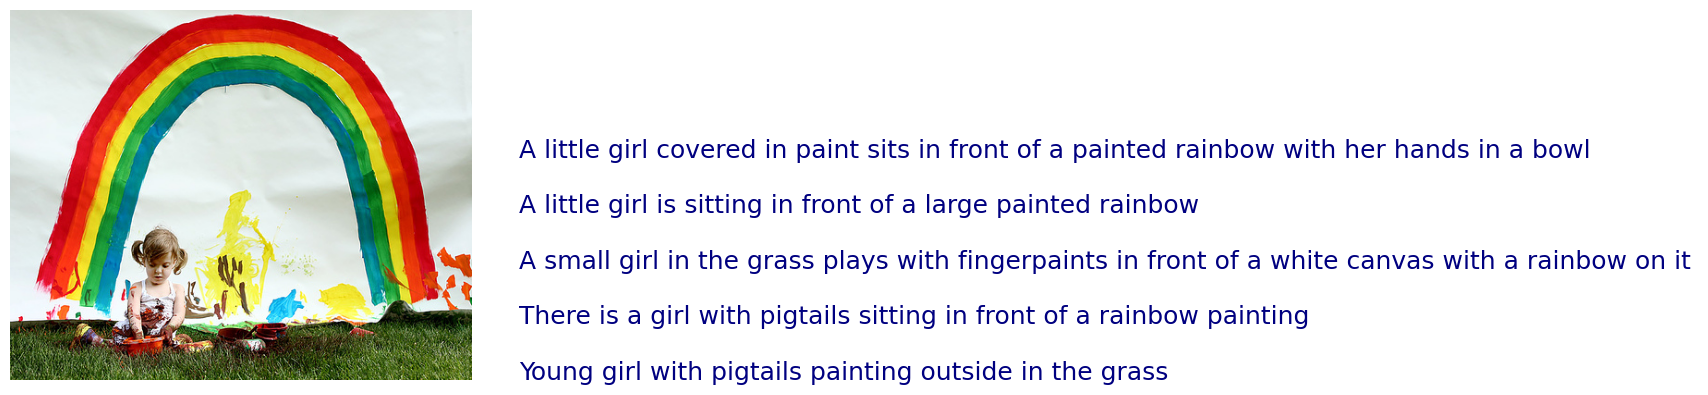

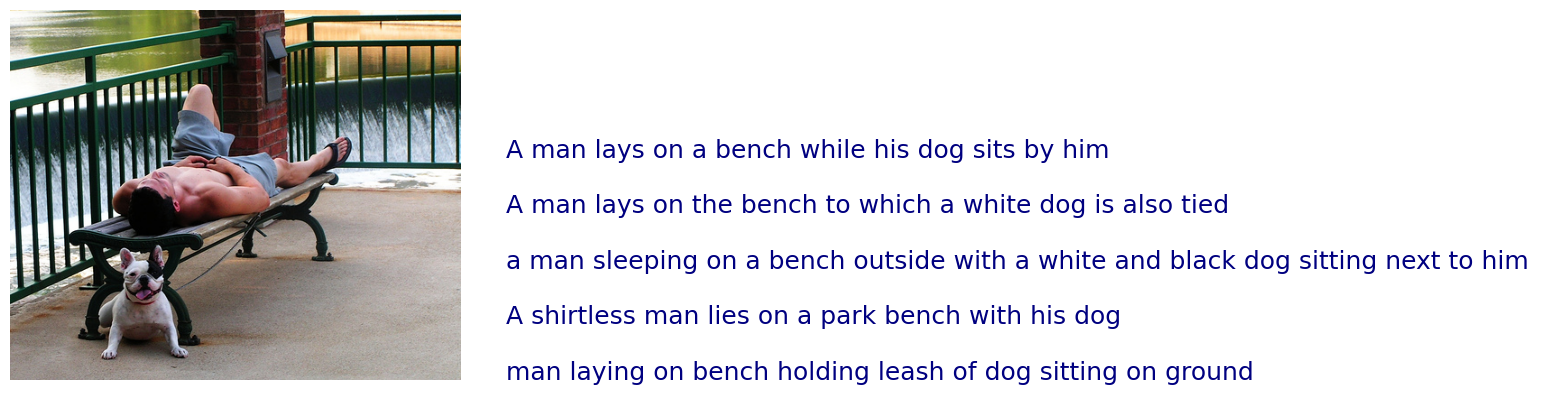

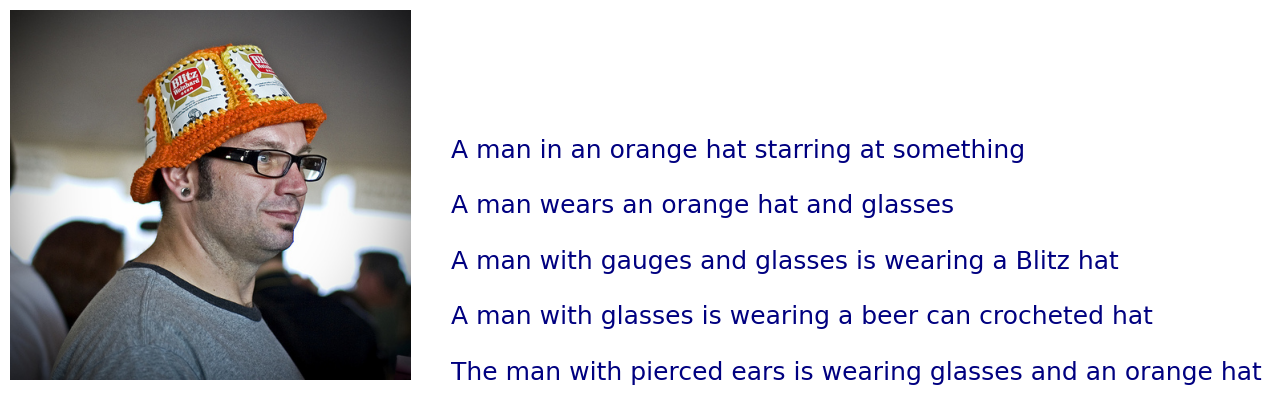

In [18]:
for r in range(0,5) :
    plot_img_cap(df['Image ID'].drop_duplicates().iloc[r], df)

In [19]:
# Preprocessing the text data
import string
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(captions)) :
    line = captions[r]
    line = line.split()

    line = [word.lower() for word in line]
    line = [word.translate(rem_punct) for word in line]
    line = [word for word in line if len(word) > 1]
    line = [word for word in line if word.isalpha()]

    captions[r] = ' '.join(line)

captions = ['<start>' + ' ' + line + ' ' + '<end>' for line in captions]
captions[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

# check pip3 and python version

In [20]:
! which pip3
! which python3
! pip3 --version

/usr/local/bin/pip3
/usr/bin/python3
pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [21]:
import sys
print(sys.executable)

/usr/bin/python3


In [22]:
! pip3 show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [23]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.activations import softmax, tanh, relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE


In [24]:
# print(sys.executable)
import tensorflow as tf
import keras
#

# Tokenizing the captions
import keras.preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
counter_2 = 5000
tokenizer = Tokenizer(num_words = counter_2+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False,
                      oov_token = 'UNK')
tokenizer.fit_on_texts(captions)
seqs = tokenizer.texts_to_sequences(captions)
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'   # Adding padding to words

seqs_len = [len(seq) for seq in seqs]
longest = max(seqs_len)
cap_vector= pad_sequences(seqs, padding= 'post', maxlen = longest,
                                                          dtype='int32', value=0)

cap_vector.shape


(40455, 31)

In [25]:
preprocessed = []
IMAGE_SHAPE = (255, 255)
def load_images(image_path):
    img = read_file(image_path, name = None)
    img = decode_jpeg(img, channels=0)
    img = resize(img, IMAGE_SHAPE)
    img = preprocess_input(img)
    return img, image_path
new_paths = sorted(set(img_path))
new_images = Dataset.from_tensor_slices(new_paths)
new_images = new_images.map(load_images, num_parallel_calls = AUTOTUNE)
new_images = new_images.batch(64, drop_remainder=False)
new_images

<_BatchDataset element_spec=(TensorSpec(shape=(None, 255, 255, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [26]:
img_train, img_test, cap_train, cap_test = train_test_split(img_path, cap_vector, test_size = 0.2, random_state = 42)
print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [27]:
# Load the InceptionV3 model for extracting features
img_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_inp = img_model.input
hidden = img_model.layers[-1].output
extractor = tf.compat.v1.keras.Model(new_inp, hidden)

87910968/87910968 [==============================] - 5s 0us/step


In [28]:
# print the model summary
extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [ ]:
#  feature extraction
# use gpu; this will work much faster
img_features = {}
for img, img_path in tqdm(new_images):

    batch_features = extractor(img)
    batch_features_flat = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for batch_feat, path in zip(batch_features_flat, img_path):
        feat_path = path.numpy().decode('utf-8')
        img_features[feat_path] = batch_feat.numpy()

 48%|████▊     | 61/127 [00:52<00:29,  2.27it/s]

In [ ]:
len(img_features)
batch_feat.shape

In [ ]:
def map(img_name, cap):
    img_tensor = img_features[img_name.decode('utf-8')]
    return img_tensor, cap
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_ds(img, cap):

    data = Dataset.from_tensor_slices((img, cap))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = AUTOTUNE)

    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(AUTOTUNE))

    return data


In [ ]:
train_ds = gen_ds(img_train, cap_train)
test_ds = gen_ds(img_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_ds))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

Model Building

In [ ]:
# tried to use metal perrformance shaders (MPS) with code/tensorflow, but support for GRU is limited

In [ ]:
! python3 -m pip install tensorflow-metal

In [ ]:
! pip3 show tensorflow-metal

In [ ]:
# use tensorflow metal
import tensorflow as tf
print("All available devices:")
print(tf.config.list_physical_devices())
print("\nGPUs available:")
print(tf.config.list_physical_devices('GPU'))

In [ ]:
# import tensorflow as tf
# from keras.layers import SimpleRNN
# from keras.models import Sequential
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#
# model_rnn = Sequential()
# model_rnn.add(SimpleRNN(units=20, activation='relu', input_shape=(10,5)))
#
# # print the device


In [ ]:
embedding_dim = 256
units = 512

vocab_size = 5001
train_steps = len(img_train) // BATCH_SIZE
test_steps = len(img_test) // BATCH_SIZE

max_length = 31
feat_shape = batch_feat.shape[1]
attn_feat_shape = batch_feat.shape[0]

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim)

    def call(self, features):
        features =  self.dense(features)
        features =  relu(features, max_value=None, threshold=0)
        return features

encoder=Encoder(embedding_dim)

In [ ]:
class Attn_model(Model):
    def __init__(self, units):
        super(Attn_model, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)
        self.units=units

    def call(self, features, hidden):

        hidden_time = hidden[:, tf.newaxis]
        score = tanh(self.W1(features) + self.W2(hidden_time))
        attn_weights = softmax(self.V(score), axis=1)
        context_vector = attn_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attn_weights

In [ ]:
# variation of attention model

class AttentionModel2(Model):
    def __init__(self, units, dropout_rate=0.1, use_multi_vector=False):
        # attempting to use multi dimensional attention vectors so attention can focus on multipple things at once
        super(AttentionModel2, self).__init__()
        self.W1 = Dense(units, activation='relu')  # relu
        self.W2 = Dense(units, activation='relu')
        self.dropout = Dropout(dropout_rate)       # dropout
        if use_multi_vector:
            self.V = Dense(units)
        else:
            self.V = Dense(1)
        self.units = units
        self.use_multi_vector = use_multi_vector

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        # dropout
        features_dropped = self.dropout(features)
        hidden_dropped = self.dropout(hidden_with_time_axis)

        score = self.W1(features_dropped) + self.W2(hidden_dropped)
        if self.use_multi_vector:
            score = tf.nn.tanh(score) # tanh for using multi-vector for more stable gradients

        attn_weights = softmax(self.V(score), axis=1)


        context_vector = attn_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attn_weights

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # print(f"Decoder Units: {self.units}")
        self.attention = Attn_model(self.units)
        self.embed = Embedding(vocab_size, embed_dim)
        self.gru = GRU(self.units, return_sequences=True, return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = Dense(self.units)
        self.d2 = Dense(vocab_size)


    def call(self,x,features, hidden):
        context_vector, attn_weights = self.attention(features, hidden)
        # print(context_vector.shape)
        # print(attn_weights.shape)
        embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # print(embed.shape)
        # print(embed.shape)
        # x = self.gru(embed)
        # print(x)
        # output, state = self.gru(embed)
        # print(self.gru)
        gru_output = self.gru(embed)
        # print(f"GRU Output Type: {type(gru_output)}")
        # print(f"GRU Output Length: {len(gru_output)}")
        output, state = gru_output
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)

        return output, state, attn_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

decoder = Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_in = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

pred, hidden_out, attn_weights= decoder(dec_in, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(pred.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attn_weights.shape)) #(batch, 8*8, embed_dim)

In [ ]:
# testing gru function #1

import tensorflow as tf
from tensorflow.keras.layers import GRU, Input
from tensorflow.keras.models import Model

# Define a simple GRU layer
input_layer = Input(shape=(None, 10))
gru_layer = GRU(512, return_sequences=True, return_state=True)(input_layer)
model = Model(inputs=input_layer, outputs=gru_layer)

# Create dummy data to pass through the model
dummy_input = tf.random.normal([64, 10, 10])

# Run the model
outputs = model(dummy_input)

# Check the number of outputs
print(f'Number of outputs from GRU: {len(outputs)}')
for output in outputs:
    print(output.shape)

In [ ]:
# testing gru function #2

import tensorflow as tf

# Define a GRU layer
gru_layer = tf.keras.layers.GRU(256, return_sequences=True, return_state=True)

# Create a test input (batch_size, sequence_length, features)
test_input = tf.random.normal([1, 10, 100])
print("Test input shape:", test_input.shape)

# Run the test input through the GRU layer
outputs, state = gru_layer(test_input)

print("Output shape:", outputs.shape)  # Should be (1, 10, 256)
print("State shape:", state.shape)     # Should be (1, 256)


In [ ]:
# testing gru 3
import tensorflow as tf
from tensorflow.keras.layers import GRU

# Define GRU layer
units = 512
gru_layer = GRU(units, return_sequences=True, return_state=True)

# Create dummy input
dummy_input = tf.random.normal([1, 10, units])  # Batch size of 1, 10 timesteps, 'units' features

# Run GRU layer
gru_output = gru_layer(dummy_input)
print(f"GRU Output Type: {type(gru_output)}")
print(f"GRU Output Length: {len(gru_output)}")
output, state = gru_output

# Output shapes
print(f'Sequence output shape: {output.shape}')
print(f'Final state shape: {state.shape}')

In [ ]:
optimizer = Adam(learning_rate = 0.001)
loss_object = SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:

        encoder_op = encoder(img_tensor)

        for r in range(1, target.shape[1]) :
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions)
            dec_input = tf.expand_dims(target[:, r], 1)

    avg_loss = (loss/int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

@tf.function
def test_step(img_tensor, target):
    loss = 0

    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)

        for r in range(1, target.shape[1]) :
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions)

            dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)

    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss = total_loss + t_loss
        avg_test_loss = total_loss/ test_steps

    return avg_test_loss

In [ ]:
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100

for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_ds):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss = total_loss / train_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_ds)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.433, & test loss is 1.207
Time taken for 1 epoch 183.99763345718384 sec

Test loss has been reduced from 100.000 to 1.207


  7%|▋         | 1/15 [03:04<42:59, 184.25s/it]

For epoch: 2, the train loss is 1.115, & test loss is 1.066
Time taken for 1 epoch 52.48714900016785 sec

Test loss has been reduced from 1.207 to 1.066


 20%|██        | 3/15 [04:49<16:26, 82.25s/it] 

For epoch: 3, the train loss is 1.013, & test loss is 0.980
Time taken for 1 epoch 52.669819593429565 sec

Test loss has been reduced from 1.066 to 0.980
For epoch: 4, the train loss is 0.942, & test loss is 0.917
Time taken for 1 epoch 51.64887976646423 sec

Test loss has been reduced from 0.980 to 0.917


 27%|██▋       | 4/15 [05:41<12:53, 70.28s/it]

For epoch: 5, the train loss is 0.884, & test loss is 0.864
Time taken for 1 epoch 54.11501932144165 sec

Test loss has been reduced from 0.917 to 0.864


 33%|███▎      | 5/15 [06:36<10:45, 64.57s/it]

For epoch: 6, the train loss is 0.834, & test loss is 0.816
Time taken for 1 epoch 52.53733706474304 sec

Test loss has been reduced from 0.864 to 0.816


 40%|████      | 6/15 [07:29<09:05, 60.59s/it]

For epoch: 7, the train loss is 0.790, & test loss is 0.771
Time taken for 1 epoch 52.63753128051758 sec

Test loss has been reduced from 0.816 to 0.771


 47%|████▋     | 7/15 [08:22<07:44, 58.07s/it]

In [ ]:
# from tensorflow.keras.utils import to_categorical, plot_model
# model2 = Model(inputs=[features_input, hidden_input], outputs=decoder_output)
# plot_model(model2, show_shapes=True)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [ ]:
def evaluate(image):
    attn_plot = np.zeros((max_length, attn_feat_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_inp = tf.expand_dims(load_images(image)[0], 0)
    img_tensor_val = extractor(temp_inp)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        pred, hidden, attn_weights = decoder(dec_input, features, hidden)

        attn_plot[i] = tf.reshape(attn_weights, (-1, )).numpy()

        pred_id = tf.argmax(pred[0]).numpy()
        result.append (tokenizer.index_word[pred_id])

        if tokenizer.index_word[pred_id] == '<end>':
            return result, attn_plot, pred

        dec_input = tf.expand_dims([pred_id], 0)

    attn_plot = attn_plot[:len(result), :]
    return result, attention_plot, pred

def plot_attn_map (caption, weights, img):
  # this will create a map for each word in the caption that shows where the attention model is focuisng
  # cool to see where certain words are focusing on certain parts of teh image
  fig = plt.figure(figsize = (10, 10))
  temp_img = np.array(Image.open(img))

  cap_len = len(caption)
  for cap in range(cap_len) :
      weights_img_1 = np.reshape(weights[cap], (6, 6))
      weights_img_2 = np.array(Image.fromarray(weights_img_1).resize((224,224), Image.LANCZOS))

      ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
      ax.set_title(caption[cap], fontsize = 14, color = 'red')

      img = ax.imshow(temp_img)

      ax.imshow(weights_img_1, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
      ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
# download this model locally so dont have to retrain

files.download('Flickr8K/checkpoint1')


In [ ]:
image_test = img_test.copy()

In [ ]:
# geneates a caption based on a random image from img_test set
def generate_caption(sample_size, bleu_weights=(0.5, 0.5, 0, 0)):
    test_captions = cap_test.copy()
    random_index = np.random.randint(0, sample_size)
    selected_image = image_test[random_index]

    actual_caption = ' '.join([tokenizer.index_word[token] for token in test_captions[random_index] if token != 0])
    predicted_caption, attention_data, _ = evaluate(selected_image)

    filtered_caption = filt_text(actual_caption)
    final_caption = ' '.join(predicted_caption).rsplit(' ', 1)[0]

    actual_words = [filtered_caption.split()]
    predicted_words = final_caption.split()

    bleu_score = sentence_bleu(actual_words, predicted_words, weights=bleu_weights)
    print(f"BLEU score: {bleu_score * 100:.2f}")
    print('Original Caption:', filtered_caption)
    print('Predicted Caption:', final_caption)

    plot_attn_map(predicted_caption, attention_data, selected_image)

    return selected_image

In [ ]:
# generates a caption based on a custom inputted image with a manually inputted caption

def custom_file_generate(custom_file, custom_caption, custom_weights=(0.5, 0.5, 0, 0)):

    processed_image = load_images(custom_file)

    # evaluate image with model function
    predicted_caption, attention_data, _ = evaluate(processed_image)

    # remove unwanted tokens
    filtered_caption = filt_text(custom_caption)

    final_caption = ' '.join(predicted_caption).rsplit(' ', 1)[0]
    actual_words = [filtered_caption.split()]
    predicted_words = final_caption.split()

    bleu_score = sentence_bleu(actual_words, predicted_words, weights=custom_weights)
    print(f"BLEU score: {bleu_score * 100:.2f}")
    print('Provided Caption:', filtered_caption)
    print('Predicted Caption:', final_caption)

    plot_attn_map(predicted_caption, attention_data, processed_image)

    return processed_image

image 1 testing

In [ ]:
from collections import Counter
import string
import time
from PIL import Image
from tqdm import tqdm
import glob
# from gtts import gTTS
# from playsound import playsound
from IPython import display
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
# image 1

test_image = generate_caption(len(image_test), bleu_weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

In [ ]:
# image 2

test_image = generate_caption(len(image_test), bleu_weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BLEU score: 80.34
Original Caption: black dog jumping into large pool
Predicted Caption: black dog jumping into the pool


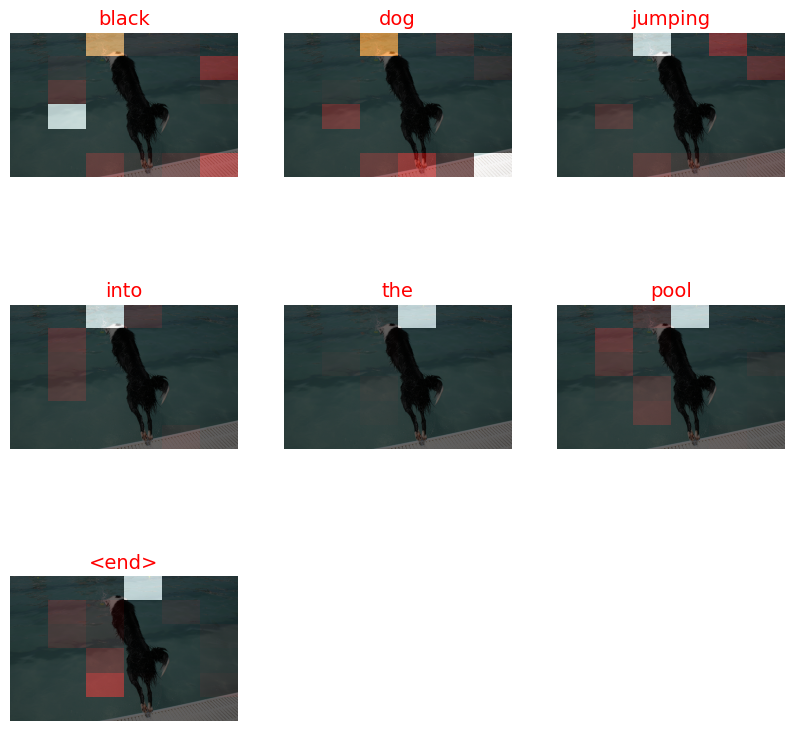

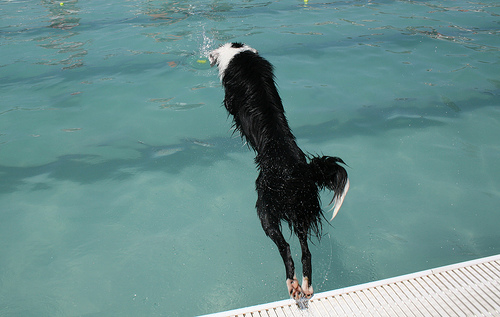

In [64]:
# image 3

test_image = generate_caption(len(image_test), bleu_weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BLEU score: 36.79
Original Caption: dog catches ball in its mouth
Predicted Caption: dog catches ball


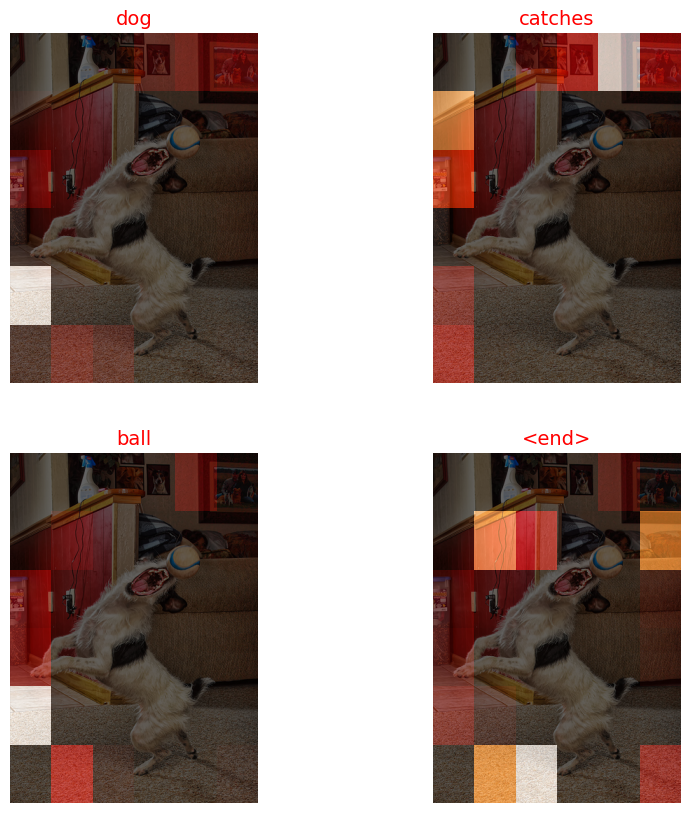

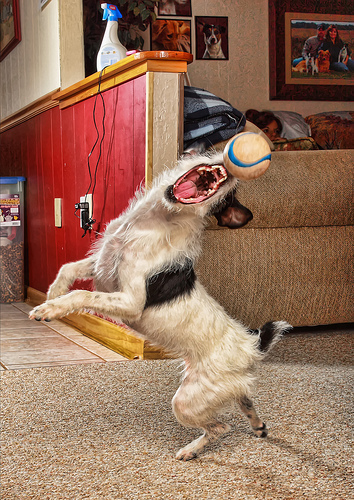

In [65]:
# image 4

test_image = generate_caption(len(image_test), bleu_weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

In [ ]:
# custom file testing
from google.colab import files
files.upload()

In [ ]:
image = '/content/basketball_image.jpg'
caption = "man about to shoot a basketball on a court while being guarded"
bleu_weights = (0.5, 0.25, 0, 0)

from IPython.display import Image
Image(filename=image)

In [ ]:
generated_image = custom_file_generate(image, caption, custom_weights=bleu_weights)